In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import enviroment_no_visual as enviroment_no_visual
import enviroment_visual as enviroment_visual
import tensorflow as tf
import keras

Implementazione di un buffer circolare che permetta inserimento/cancellazione degli elementi e accesso random veloce. 

In [30]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]
    
    def sample_experiences(self, batch_size):
        batch = self.sample(batch_size)
        states, actions, rewards, next_states, game_over = [
            np.array([experience[field_index] for experience in batch])
                        for field_index in range(5)]
        return states, actions, rewards, next_states, game_over

In [31]:
def Linear_QNet(input_shape, hidden_size, output_size):
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(hidden_size, activation='relu'),
        keras.layers.Dense(output_size)
    ])
    return model

class QTrainer:

    def __init__(self, model, lr=1e-3, gamma=0.9):
        self.model = model
        self.gamma = gamma
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.loss_fn = keras.losses.mean_squared_error
        
    def train_step(self, states, actions, rewards, next_states, dones):
        next_Q_values = self.model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        # Equazione di Bellman: Q value = reward + discount factor * expected future reward
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)

        with tf.GradientTape() as tape:
            # train the model on the states and updated Q-values
            all_Q_values = self.model(states)  # similar to action_probs
            # apply the masks to the Q-values to get the Q-value for the action taken
            Q_values = tf.reduce_sum(all_Q_values * actions, axis=1, keepdims=True)
            # calculate loss between new Q-value and old Q-value
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        # Backpropagation
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [32]:
# Espande di una dimensione. Quando si vuole (1,x) ma hai (1,)
def add_dimension(states, actions, rewards, next_states, dones):
    state = np.expand_dims(states, axis=0)
    action = np.expand_dims(actions, axis=0)
    reward = np.expand_dims(rewards, axis=0)
    next_state = np.expand_dims(next_states, axis=0)
    done = np.expand_dims(dones, axis=0)

    return state, action, reward, next_state, done

In [33]:
class Agent:

    def __init__(self, max_memory, batch_size):
        self.n_games = 0
        self.epsilon = 1  
        self.lr = 0.001 
        self.gamma = 0.9    
        self.memory = ReplayBuffer(max_size=max_memory)
        self.batch_size = batch_size
        self.model = Linear_QNet([11], 256, 3)
        self.trainer = QTrainer(self.model, lr=self.lr, gamma=self.gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_long_memory(self):
            states, actions, rewards, next_states, dones = self.memory.sample_experiences(self.batch_size)
            self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        state, action, reward, next_state, done = add_dimension(state, action, reward, next_state, done)
        self.trainer.train_step(state, action, reward, next_state, done)

    def epsilon_greedy_policy(self, state):
        self.epsilon = (80 - self.n_games)/100
        if np.random.rand() < self.epsilon:
            return np.random.randint(3)
        else:
            Q_values = self.model(state[np.newaxis])
            return np.argmax(Q_values[0])
        
    def get_action(self, state):
        final_move = [0, 0, 0]  
        move = self.epsilon_greedy_policy(state)
        final_move[move] = 1
        return final_move

    def save_model(self, model_dir_path="./DQNmodel", file_name='model.keras'):
        if not os.path.exists(model_dir_path):
            print(f"La cartella non esiste. Sarà creata con nome: {model_dir_path}")
            os.mkdir(model_dir_path)
        file_name = os.path.join(model_dir_path, file_name)
        self.model.save(file_name)

In [34]:
def train(N_GAME, visual=True):
    agent = Agent(max_memory=100_000, batch_size=5_000)
    if visual:
        env = enviroment_visual.SnakeGameAI(speed=0)
    else:
        env = enviroment_no_visual.SnakeGameAI()
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0

    while agent.n_games < N_GAME:
        state_old = env.get_state()
        final_move = agent.get_action(state_old)

        # perform move and get new state
        state_new, reward, done, score = env.play_step(final_move)

        agent.train_short_memory(state_old, final_move, reward, state_new, done)
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            env.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.save_model()

            print(f"\rGame: {agent.n_games}, Epsilon: {agent.epsilon}, Score: {score}, Record: {record}.", end="")
            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
    return plot_scores, plot_mean_scores, agent

Mostra andamento dello score per partita durante il training

In [35]:
def plot_trand(scores, mean_scores):
    plt.plot(scores, label='Score')
    plt.plot(mean_scores, label='Mean score')
    plt.title("Andamento del training")
    plt.xlabel("Partite")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

Game: 100, Epsilon: -0.19, Score: 21, Record: 32

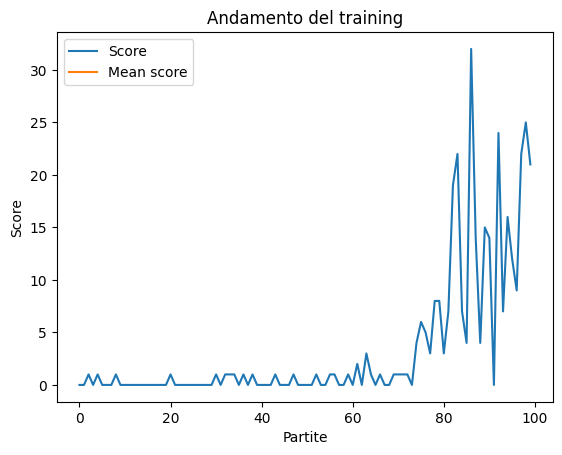

In [36]:
plot_scores, plot_mean_scores, agent = train(N_GAME=100, visual=True)
plot_trand(plot_scores, plot_mean_scores)

Carica un modello salvato

In [43]:
def load_model_from_file(model_dir_path="./DQNmodel", file_name='model.keras'):
    file_path = os.path.join(model_dir_path, file_name)
    if os.path.exists(file_path):
        print(f"Caricamento del modello da: {file_path}")
        model = keras.models.load_model(file_path)  # Carica il modello
        return model
    else:
        raise FileNotFoundError(f"Il file {file_path} non esiste.")
    
model = load_model_from_file("DQNmodel", "model.keras")

Caricamento del modello da: DQNmodel/model.keras


Testa l'Agente seguendo la policy ottimale su 100 partita e mostra le performance

In [45]:
env = enviroment_no_visual.SnakeGameAI()
MAX_N_GAMES = 10
cumulative_score = 0
max_score = 0

for n_game in range(MAX_N_GAMES):
    env.reset()
    game_over = False
    state= env.get_state()
    while not game_over:
        action = np.argmax(model(state[np.newaxis])[0])
        final_move = [0,0,0]
        final_move[action] = 1
        state, reward, game_over, score = env.play_step(final_move)
    if score > max_score:
        max_score = score
    cumulative_score += score
    print(f"\rGame: {n_game}, Score: {score}, Record: {max_score}.", end="")
    
print(f"Mean score: {cumulative_score/ MAX_N_GAMES}\nMax score: {max_score}", end="")

Game: 9, Score: 0, Record: 16.Mean score: 3.9
Max score: 16

Mostra visualmente una partita dell'Agente

In [49]:
env_visual = enviroment_visual.SnakeGameAI(speed=0)
game_over = False
state = env_visual.get_state()
while not game_over:
    action = np.argmax(model(state[np.newaxis])[0])

    final_move = [0,0,0]
    final_move[action] = 1

    state, reward, game_over, score = env_visual.play_step(final_move)